## Preprocessing the FT model and original model

In [2]:
import torch
import numpy as np
import torch.fft as ft
from torch.distributions.multivariate_normal import MultivariateNormal

## Data

I set $ \theta = b$ s.t $\mu_i = b\times i$ with a random cov

In [3]:
# Adjusting parameters
dim = 11
b = 0.5
mean_data = torch.arange(0, dim)* b
cov = torch.randn(dim, dim)
cov_data =  torch.mm(cov, cov.t())

# Simulating the data
num = 1000
dist = MultivariateNormal(mean_data, cov_data)
data = dist.sample((num,)).t()
data.shape


torch.Size([11, 1000])

In [4]:
k = (dim+1)//2
import matplotlib.pyplot as plt
from FT import FT_matrix
# Checking the implementation of FT_matrix is correct or not

# directly from cov matrix
cov = torch.cov(data)
covft = FT_matrix(cov,k).to_dense() + 1e-6*torch.eye(dim)


# from the data 
ft_data = ft.fft(data,dim = 0)[:k]
rp,ip = ft_data.real, ft_data.imag[1:k]
combined = torch.cat((rp,ip),0)
covft1 = torch.cov(combined)+ 1e-6*torch.eye(dim)
# print(combined)

check = torch.allclose(covft1, covft, atol=1e-3)
print(check)

False


In [5]:
# loading the data 
ft_data = ft.fft(data,dim = 0)[:k]
rp,ip = ft_data.real, ft_data.imag[1:k]
combined = torch.cat((rp,ip),0)
# prepare
mean_ft_data = torch.mean(combined,1)
cov_ori_data =torch.cov(data)+ 1e-6*torch.eye(dim)
mean_ori_data = torch.mean(data,1)

## Likelihood Function

The probability density of Multivariate normal distribution with the $\mu \in \mathcal{R}^m$ and $\Sigma \in \mathcal{R}^{m\times m}$ is 

$f(X_j | \mu,\Sigma ) = \frac{1}{{(2\pi)^{\frac{m}{2}} |\Sigma|^{\frac{1}{2}}}} \exp\left(-\frac{1}{2} (X_j - \mu)^T \Sigma^{-1} (X_j - \mu)\right)$

By the Definition, we can see the likelihood of Multivariate normal distribution is 

$
L(\mu, \Sigma | X_1, \ldots, X_n) = \prod_{j=1}^{n} f(X_j | \mu, \Sigma) = (2\pi)^{\frac{-nm}{2}}|det(\Sigma)|^{\frac{-n}{2}}exp(-\frac{1}{2}\sum_{j=1}^{n}(x_j-\mu)^T\Sigma^{-1}(x_j-\mu))
$

After we apply the FFT(dFT) with the truncation number k, we can have the following 

$
L(A\mu, A\Sigma A^* | AX_1, \ldots, AX_n) = \prod_{j=1}^{n} f(AX_j | A\mu, A\Sigma A^*) = (2\pi)^{\frac{-n(2k-1)}{2}}|det(A\Sigma A^*)|^{\frac{-n}{2}}exp(-\frac{1}{2}\sum_{j=1}^{n}(Ax_j-A\mu)^T(A\Sigma A^*)^{-1}(Ax_j-A\mu))
$

The Likelihood of parameters is 

$
L( \theta,A\mu| A\Sigma A^*,AX_1, \ldots, AX_n) = \prod_{j=1}^{n} f(AX_j | \theta,A\mu, A\Sigma A^*) = (2\pi)^{\frac{-n(2k-1)}{2}}|det(A\Sigma A^*)|^{\frac{-n}{2}}exp(-\frac{1}{2}\sum_{j=1}^{n}(Ax_j-A\mu)^T(A\Sigma A^*)^{-1}(Ax_j-A\mu))
$



tensor([30.9382, 32.2403])
tensor([21.2155, 22.5177])
[9.722681045532227, 9.722677230834961]


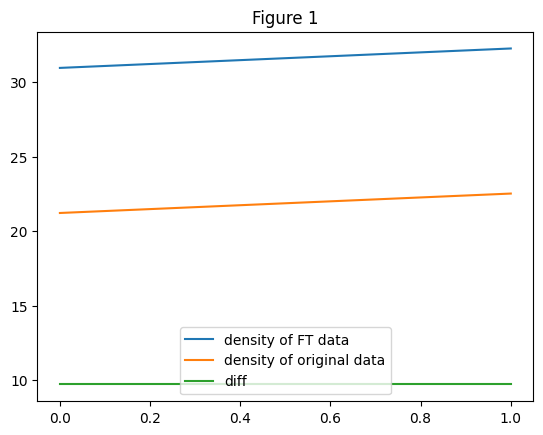

In [6]:
import matplotlib.pyplot as plt
num = 2

# take first two data 
# For the augmented of FT data
pdf1 = -torch.distributions.MultivariateNormal(mean_ft_data, covft1).log_prob(combined[:,:num].t())
print(pdf1)
# For the of original data
pdf2 = -torch.distributions.MultivariateNormal(mean_ori_data, cov_ori_data).log_prob(data[:,:num].t())
print(pdf2)

# plot as a line and plot the difference
n = num
pdf1v = pdf1.tolist()[:n]
pdf2v = pdf2.tolist()[:n]
x = list(range(0, n))
diff = [a-b for a, b in zip(pdf1v, pdf2v)]
plt.plot(x, pdf1v, label = "density of FT data ")
plt.plot(x, pdf2v, label = "density of original data")
plt.plot(x, diff, label = "diff")
# print(diff)
plt.legend()
plt.title("Figure 1")
print(diff)



## Likelihood of Parameter

This block show that likelihood of every data keep a constant distance between the FT version and the non-FT version

tensor([9.7227, 9.7227])


Text(0.5, 1.0, 'Figure 2')

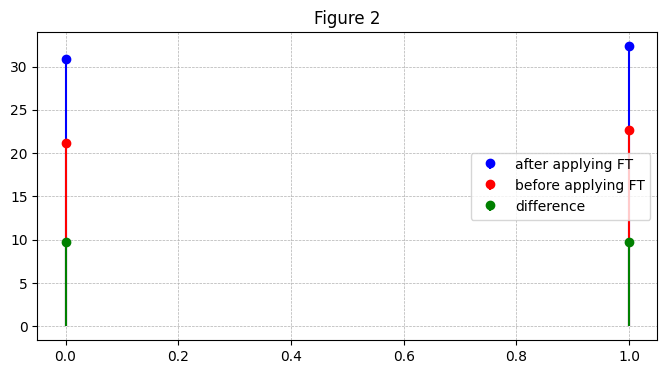

In [7]:
s = 0.5
def negative_log_likelihood(params):
    b = params
    mu = b * torch.arange(0, dim)
    mean_fft = ft.fft(mu)[:k]
    rp, ip = mean_fft.real, mean_fft.imag
    mean_transformed = torch.cat((rp, ip[1:k]), 0)
    
    # Fourier transform and covariance computation
    nll_values = -torch.distributions.MultivariateNormal(mean_transformed, covft1).log_prob(combined[:,:num].t())

    return nll_values.sum(), nll_values

total_nll, individual_nll = negative_log_likelihood(s)


def negative_log_likelihood1(params):
    b = params
    mu = b * torch.arange(0, dim)
    nll_values = -torch.distributions.MultivariateNormal(mu, cov_ori_data).log_prob(data[:,:num].t())
    return nll_values.sum(), nll_values

total_nll1, individual_nll1 = negative_log_likelihood1(s)

diff =  individual_nll - individual_nll1
print(diff)

# Plot
plt.figure(figsize=(8, 4))
plt.stem(range(len(individual_nll)), individual_nll, linefmt='-b', markerfmt='ob',basefmt=" ",label="after applying FT")
plt.stem(range(len(individual_nll1)), individual_nll1, linefmt='-r', markerfmt='or',basefmt=" ",label="before applying FT")
plt.stem(range(len(diff)), diff, linefmt='-g', markerfmt='og',basefmt=" ",label="difference")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Figure 2")

Clearly, we can expect the difference of total(sum of) likelihood as 0.693 $\times$ 1000. In the following experiment, we can see it too 

tensor(63.2346) 0.5
tensor(43.7893) 0.5
tensor(19.4454)
diff [tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454), tensor(19.4454)]


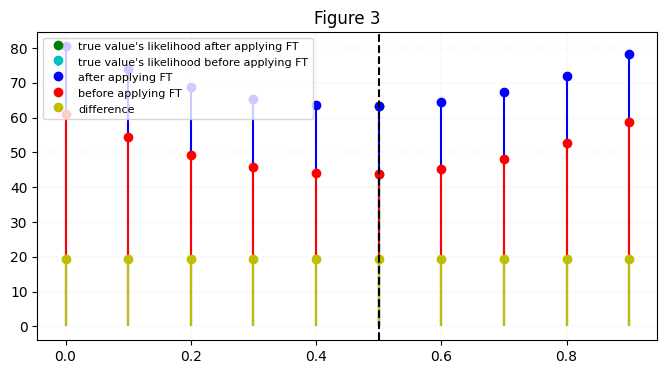

In [8]:
# simplified version of the above code
s = torch.arange(0.0, 1.0,0.1).numpy()
nll1 = []
nll = []
diff = []
for i in s:
    nll1.append(negative_log_likelihood1(i)[0])
    nll.append(negative_log_likelihood(i)[0])
    diff.append(nll[-1] - nll1[-1])

plt.figure(figsize=(8, 4))
plt.stem(0.5, total_nll, linefmt='-g', markerfmt='g',basefmt=" ",label="true value's likelihood after applying FT")
plt.stem(0.5, total_nll1, linefmt='-c', markerfmt='c',basefmt=" ",label = "true value's likelihood before applying FT")
plt.stem(s, nll, linefmt='-b', markerfmt='ob',basefmt=" ",label="after applying FT")
plt.stem(s, nll1, linefmt='-r', markerfmt='or',basefmt=" ",label="before applying FT")
plt.stem(s, diff, linefmt='-y', markerfmt='oy',basefmt=" ",label="difference")
plt.legend()
plt.legend(loc='upper left', prop={'size': 8})
plt.grid(True, which="both", linestyle="--", linewidth=0.1)


# add a line to show the true value
plt.axvline(x=0.5, color='k', linestyle='--')

# print the minimum value and the corresponding s
print(min(nll), s[nll.index(min(nll))])
print(min(nll1), s[nll1.index(min(nll1))])
print(min(nll) - min(nll1))
plt.title("Figure 3")
print("diff",diff)

